In [1]:
import sqlite3
import numpy as np
import pandas as pd
from sql import run
run.prettytable.__dict__.setdefault('DEFAULT',run.prettytable.DEFAULT)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

C:\Users\User\AppData\Local\Temp\ipykernel_6808\3118620981.py:5: DeprecationWarning: the 'DEFAULT' constant is deprecated, use the 'TableStyle' enum instead
  run.prettytable.__dict__.setdefault('DEFAULT',run.prettytable.DEFAULT)


# FOR SEVERE DAMAGE IN DISTRICT 28

In [2]:
def wrangle(db_path):
    conn = sqlite3.connect(db_path)
    query = '''
    select distinct(i.building_id) as b_id, b.*,bu.damage_grade from id_map i
    join building_structure b on b.building_id = i.building_id
    join building_damage bu on i.building_id = bu.building_id
    where i.district_id = 28
    '''
    df = pd.read_sql(query,conn,index_col='b_id')

    drop_cols = [col for col in df.columns if 'post_eq' in col]

    df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
    df['severe_damage'] = (df['damage_grade'] > 3).astype(int)

    drop_cols.append('damage_grade')
    drop_cols.append('count_floors_pre_eq')
    drop_cols.append('building_id')

    df.drop(columns=drop_cols, inplace=True)
    return df

In [3]:
df = wrangle("C:\\Users\\User\\Downloads\\nepal_eq.db")
df.head()

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,severe_damage
b_id,,,,,,,,,,,,
2.801020e+11,7,Mud mortar-Stone/Brick,Mud,14,Flat,TImber/Bamboo-Mud,Rectangular,200,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
2.801010e+11,18,Mud mortar-Stone/Brick,Mud,15,Moderate slope,Timber-Planck,Rectangular,450,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,0
2.801010e+11,20,Mud mortar-Stone/Brick,Mud,15,Moderate slope,Timber-Planck,Rectangular,500,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
2.801010e+11,21,Mud mortar-Stone/Brick,Mud,24,Moderate slope,Timber-Planck,Rectangular,350,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,0
2.801010e+11,20,Mud mortar-Stone/Brick,Mud,24,Moderate slope,TImber/Bamboo-Mud,Rectangular,280,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77148 entries, 280102000961.0 to 286209000691.0
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            77148 non-null  int64 
 1   foundation_type         77148 non-null  object
 2   ground_floor_type       77148 non-null  object
 3   height_ft_pre_eq        77148 non-null  int64 
 4   land_surface_condition  77148 non-null  object
 5   other_floor_type        77148 non-null  object
 6   plan_configuration      77148 non-null  object
 7   plinth_area_sq_ft       77148 non-null  int64 
 8   position                77148 non-null  object
 9   roof_type               77148 non-null  object
 10  superstructure          77148 non-null  object
 11  severe_damage           77148 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.7+ MB


In [5]:
class_counter = Counter(df['severe_damage'])
class_counter

Counter({1: 63579, 0: 13569})

In [11]:
class_counter_over = Counter(y_resampled)
class_counter_over

Counter({1: 63579, 0: 63579})

In [10]:
ros = RandomOverSampler()
X_resampled,y_resampled = ros.fit_resample(X,y)

In [12]:
foundation_pivot = pd.pivot_table(
    df,index = 'foundation_type',values = 'severe_damage',aggfunc='mean').sort_values(by='severe_damage')
foundation_pivot

,severe_damage
foundation_type,
RC,0.050481
Other,0.247863
Bamboo/Timber,0.454545
Cement-Stone/Brick,0.593092
Mud mortar-Stone/Brick,0.866976


In [13]:
major,minor = df.severe_damage.value_counts(normalize=True)

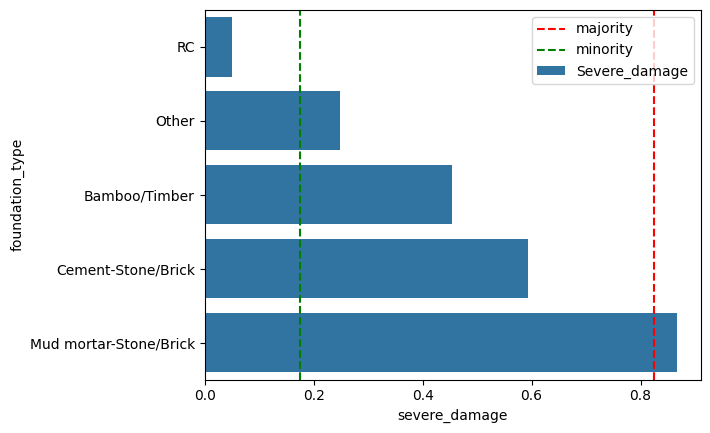

In [14]:
sns.barplot(data=foundation_pivot,x='severe_damage',y='foundation_type',label='Severe_damage')
plt.axvline(
    major,linestyle='--',color='red',label='majority'
)
plt.axvline(
    minor,linestyle='--',color='green',label='minority'
)
plt.legend(loc = 'upper right');

In [15]:
target = 'severe_damage'
X = df.drop(target,axis=1)
y = df[target]

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=30)

In [19]:
model = Pipeline(
    [
        ('oh',OneHotEncoder(use_cat_names='mean')),
        ('ss',StandardScaler()),
        ('dt',DecisionTreeClassifier(random_state=30))
    ]
)

In [20]:
acc_baseline = y_test.value_counts(normalize=True).max()
acc_baseline

np.float64(0.5041679773513683)

In [21]:
model.fit(X_train,y_train)

Pipeline(steps=[('oh',
                 OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                                     'land_surface_condition',
                                     'other_floor_type', 'plan_configuration',
                                     'position', 'roof_type',
                                     'superstructure'],
                               use_cat_names='mean')),
                ('ss', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=30))])

In [22]:
y_predict = model.predict(X_test)

In [23]:
model.score(X_train,y_train)

0.9783831075634548

In [24]:
accuracy = accuracy_score(y_test,y_predict)
accuracy

0.9080685750235923

In [25]:
precision = precision_score(y_test,y_predict)
precision

0.9778563453665798

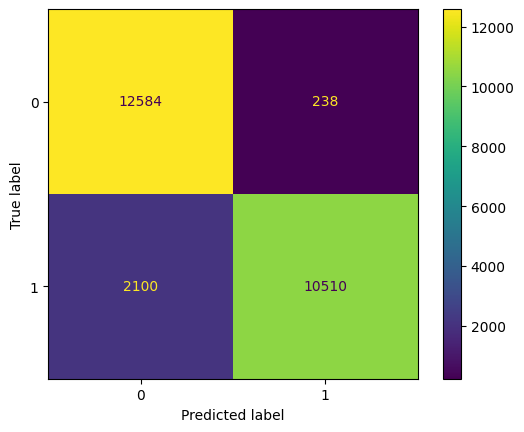

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test,y_predict)

In [27]:
feature_importances = pd.DataFrame({
    'feature': model.named_steps['oh'].get_feature_names_out(),
    'importance': model.named_steps['dt'].feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importances.head(10)

,feature,importance
29,plinth_area_sq_ft,0.285947
0,age_building,0.227322
38,superstructure_mud_mortar_stone,0.155348
11,height_ft_pre_eq,0.129861
37,superstructure_adobe_mud,0.024726
12,land_surface_condition_Flat,0.018517
30,position_Not attached,0.016477
14,land_surface_condition_Moderate slope,0.014593
16,other_floor_type_TImber/Bamboo-Mud,0.013385
15,other_floor_type_Timber-Planck,0.012909


<Axes: xlabel='importance', ylabel='feature'>

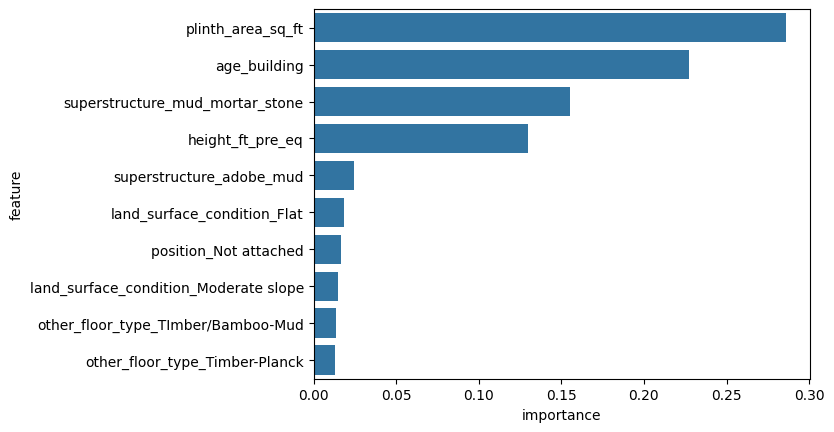

In [28]:
sns.barplot(data=feature_importances.head(10),x='importance',y='feature')

# FOR DAMAGE LEVEL OF DISTRICT 28

In [54]:
def wrangle1(db_path):
    conn = sqlite3.connect(db_path)
    query = '''
    select distinct(i.building_id) as b_id, b.*,bu.damage_grade from id_map i
    join building_structure b on b.building_id = i.building_id
    join building_damage bu on i.building_id = bu.building_id
    where i.district_id = 28
    '''
    df = pd.read_sql(query,conn,index_col='b_id')

    drop_cols = [col for col in df.columns if 'post_eq' in col]

    df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
    # df['severe_damage'] = (df['damage_grade'] > 3).astype(int)

    # drop_cols.append('damage_grade')
    drop_cols.append('count_floors_pre_eq')
    drop_cols.append('building_id')

    df.drop(columns=drop_cols, inplace=True)
    return df

In [55]:
df1 = wrangle1("C:\\Users\\User\\Downloads\\nepal_eq.db")
df1.head()

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,damage_grade
b_id,,,,,,,,,,,,
2.801020e+11,7,Mud mortar-Stone/Brick,Mud,14,Flat,TImber/Bamboo-Mud,Rectangular,200,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,5
2.801010e+11,18,Mud mortar-Stone/Brick,Mud,15,Moderate slope,Timber-Planck,Rectangular,450,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,3
2.801010e+11,20,Mud mortar-Stone/Brick,Mud,15,Moderate slope,Timber-Planck,Rectangular,500,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,4
2.801010e+11,21,Mud mortar-Stone/Brick,Mud,24,Moderate slope,Timber-Planck,Rectangular,350,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,3
2.801010e+11,20,Mud mortar-Stone/Brick,Mud,24,Moderate slope,TImber/Bamboo-Mud,Rectangular,280,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone,5


In [56]:
df1.damage_grade.unique()

array([5, 3, 4, 1, 2])

In [57]:
foundation_pi = pd.pivot_table(
    df1,index = 'foundation_type',values = 'damage_grade',aggfunc='mean').sort_values(by='damage_grade')
foundation_pi

,damage_grade
foundation_type,
RC,1.685096
Other,2.478632
Bamboo/Timber,2.935065
Cement-Stone/Brick,3.550259
Mud mortar-Stone/Brick,4.381821


In [58]:
one,two,three,four,five = df1.damage_grade.value_counts(normalize=True)
print(one,two,three,four,five)

0.5223077720744543 0.3018095089956966 0.10640586923834708 0.035580961269248715 0.03389588842225333


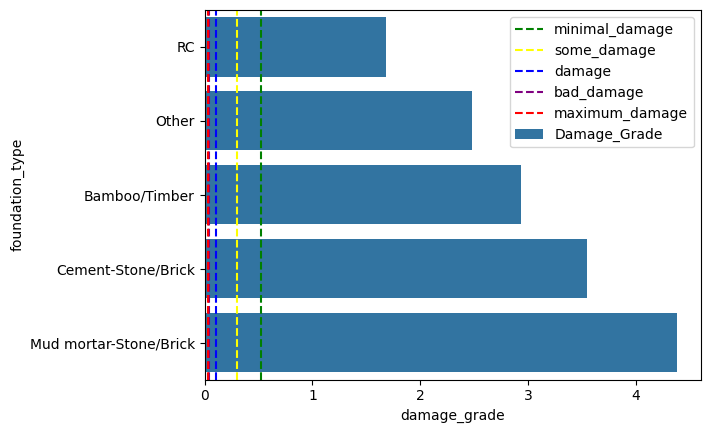

In [59]:
sns.barplot(data=foundation_pi,x='damage_grade',y='foundation_type',label='Damage_Grade')
plt.axvline(
    one,linestyle='--',color='green',label='minimal_damage'
)
plt.axvline(
    two,linestyle='--',color='yellow',label='some_damage'
)
plt.axvline(
    three,linestyle='--',color='blue',label='damage'
)
plt.axvline(
    four,linestyle='--',color='purple',label='bad_damage'
)
plt.axvline(
    five,linestyle='--',color='red',label='maximum_damage'
)
plt.legend(loc = 'upper right');

In [60]:
target = 'damage_grade'
inputs = df1.drop(target,axis=1)
X = inputs
y = df1[target]

In [61]:
model1 = Pipeline(
    [
        ('oh',OneHotEncoder(use_cat_names=True)),
        ('ss',StandardScaler()),
        ('dt',DecisionTreeClassifier(random_state=30))
    ]
)

In [62]:
acc_baseline1 = y_test.value_counts(normalize=True).max()
acc_baseline1

np.float64(0.20106712991686312)

In [63]:
X_resample,y_resample = ros.fit_resample(X,y)

In [64]:
class_counter_over = Counter(y_resampled)
class_counter_over

Counter({1: 63579, 0: 63579})

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X_resample,y_resample,test_size=0.2,random_state=30)

In [66]:
model1.fit(X_train,y_train)

Pipeline(steps=[('oh',
                 OneHotEncoder(cols=['foundation_type', 'ground_floor_type',
                                     'land_surface_condition',
                                     'other_floor_type', 'plan_configuration',
                                     'position', 'roof_type',
                                     'superstructure'],
                               use_cat_names=True)),
                ('ss', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=30))])

In [67]:
y_pred = model1.predict(X_test)

In [68]:
model1.score(X_train,y_train)

0.96320263059933

In [69]:
import pickle

In [70]:
with open('Nepal_28_model(Damage_Grade).pkl','wb') as f:
    pickle.dump(model1,f)

In [46]:
accuracy1 = accuracy_score(y_test,y_pred)
accuracy1

0.8464573768457625

In [47]:
precision1 = precision_score(y_test,y_pred,average='macro')
precision1

0.842028521599471

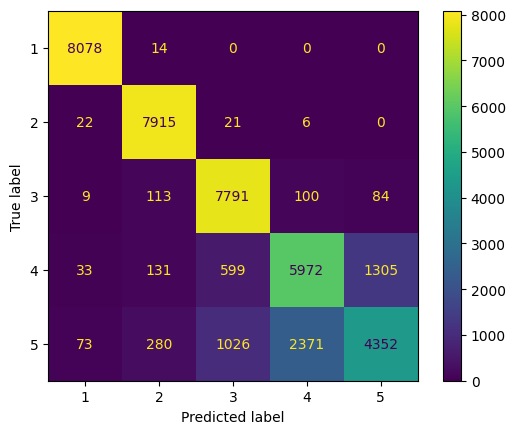

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [49]:
feature_impotance1 = pd.DataFrame(
    {
        'feature': model1.named_steps['oh'].get_feature_names_out(),
        'weights': model1.named_steps['dt'].feature_importances_
    }                                        
).sort_values(by='weights',ascending=False)
feature_impotance1.head(10)

,feature,weights
29,plinth_area_sq_ft,0.294936
0,age_building,0.258079
38,superstructure_mud_mortar_stone,0.120301
11,height_ft_pre_eq,0.101624
30,position_Not attached,0.023258
31,position_Attached-1 side,0.022823
39,superstructure_adobe_mud,0.019678
12,land_surface_condition_Flat,0.015623
13,land_surface_condition_Moderate slope,0.013789
32,position_Attached-2 side,0.010211


<Axes: xlabel='weights', ylabel='feature'>

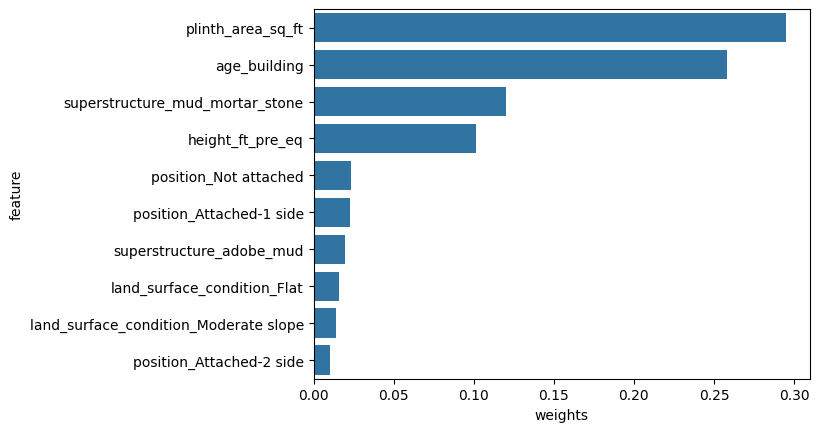

In [50]:
sns.barplot(data=feature_impotance1.head(10),x='weights',y='feature')